# Photo to Monet Style Transformation using CycleGANs

1. GitHub URL: https://github.com/XieXiao94/5511-Photo-to-Monet-Style-Transformation-using-CycleGANs-/blob/main/Photo_to_Monet_Style_Transformation_Using_CycleGANs.ipynb

2. About this project:

    This project studying 300 monet images to  learn his unique painting style. Then it transfer other photos to monet style.  The type of learning is deep learning using CycleGan techniques.

3. Data Source:

    The dataset is from a kaggle project named ' I’m Something of a Painter Myself'.

4. Citation:

    I’m Something of a Painter Myself. (n.d.). Kaggle. https://www.kaggle.com/competitions/gan-getting-started/overview

5. Dataset:

    The dataset contains monet_tfrec, photo_tfrec, monet_jpg and photo_jpg. monet_trfec and monet_jpg contain the same images but stored differently. Same with photo_tfrec and photo_jpg. This project will be working with tfrecord file (tfrec). Monet_tfrec has 300 images. Photo_tfrec has 7038 images.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from PIL import Image
import shutil


## Load dataset


In [ ]:
# Decode the serialized data from TFrecord file to Tensorflow tensors formate.

photo = 'photo_tfrec/*.tfrec'
monet = 'monet_tfrec/*.tfrec'

monet_ds= tf.data.TFRecordDataset(tf.io.gfile.glob(monet))
photo_ds= tf.data.TFRecordDataset(tf.io.gfile.glob(photo))

def decode_function(proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    decoded_features = tf.io.parse_single_example(proto, features)

    image = tf.image.decode_jpeg(decoded_features['image'], channels=3)

    return image


monet_ds = monet_ds.map(decode_function)
photo_ds = photo_ds.map(decode_function)



In [ ]:
def ds_size(ds, name):
    count = 0
    for image in ds:
        count += 1

    print(f"{name} dataset has: {count} images")

ds_size(monet_ds, "Monet")
ds_size(photo_ds, "Photo")

Monet dataset has: 300 images
Photo dataset has: 7038 images


## Image Visualization

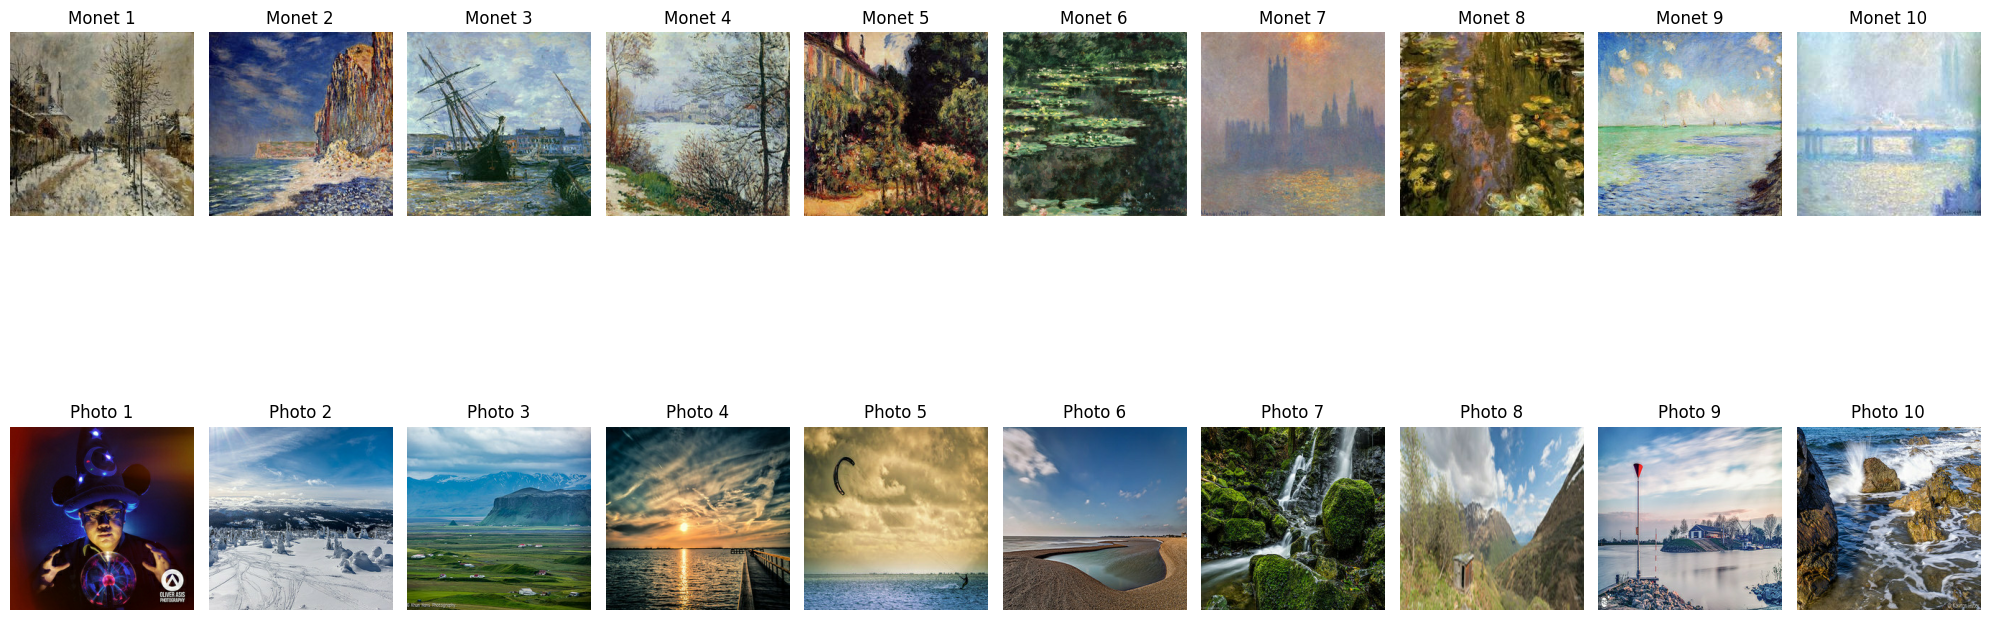

In [ ]:
# Comparsion between Monet Paints and Photos

fig, axes = plt.subplots(2, 10, figsize=(20, 10))
axes = axes.flatten()

for i, image in enumerate(monet_ds.take(10)):
    axes[i].imshow(image.numpy().astype("uint8"))
    axes[i].set_title(f'Monet {i+1}')
    axes[i].axis('off')

for i, image in enumerate(photo_ds.take(10)):
    axes[i+10].imshow(image.numpy().astype("uint8"))
    axes[i+10].set_title(f'Photo {i+1}')
    axes[i+10].axis('off')

plt.tight_layout()
plt.show()

## Preprocessing

1. Resizes all the images to 256 x 256 pixels
2. Normaliz the images to range [-1,1]

In [ ]:
def preprocess(image):
    image = tf.image.resize(image, [256, 256])

    image = (image / 127.5) - 1.0

    return image


monet_ds = monet_ds.map(preprocess)
photo_ds = photo_ds.map(preprocess)




## Exploratory Data Analysis

To understand monet painting style:

1. Statistical Analysis

 Comparison of Mean RGB between Monet and Photo

  a. The mean RGB for Monet's painting is higher than the photo.

 Comparison of STD RGB between Monet and Photo

  b. STD RGB for Monet painting is higher than the photo.

  Monet paints have higher intensity and more variability in colour compared with photos.

2. Color analyst for 10 images

  Monet's painting Colour Histogram
   
  a. The pixel value for Monet's painting peaks at -0.2 to 0.50.

  Photos Colour Histogram
      
  b. The pixel value for photos have a much peaks at -1.


  It means Monet uses more colour blending in his paintings. The colour in photos is more distinct, such as dark colour.

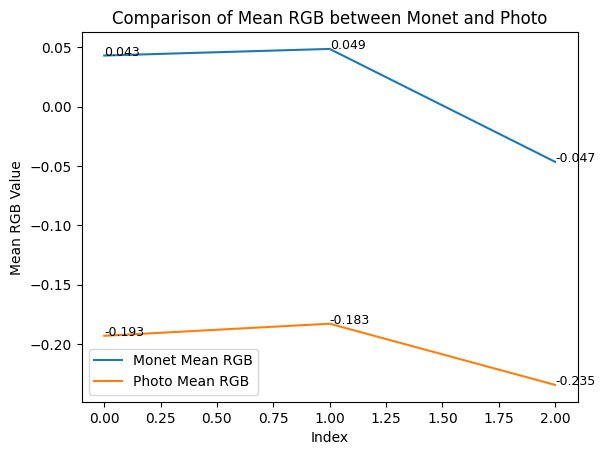

In [ ]:
def plot_mean (ds, label1, fig_size=(20, 15)):
    mean = []

    for image in ds:
        mean.append(tf.reduce_mean(image, axis=[0,1]).numpy())

    mean = np.mean(mean, axis=0)

    plt.plot(mean, label =label1)

    for i, value in enumerate(mean):
        plt.text(i, value, f'{value:.3f}', fontsize=9, ha='left')

    plt.title('Comparison of Mean RGB between Monet and Photo')
    plt.xlabel('Index')
    plt.ylabel('Mean RGB Value')
    plt.legend()

plot_mean(monet_ds, 'Monet Mean RGB')
plot_mean(photo_ds,'Photo Mean RGB')


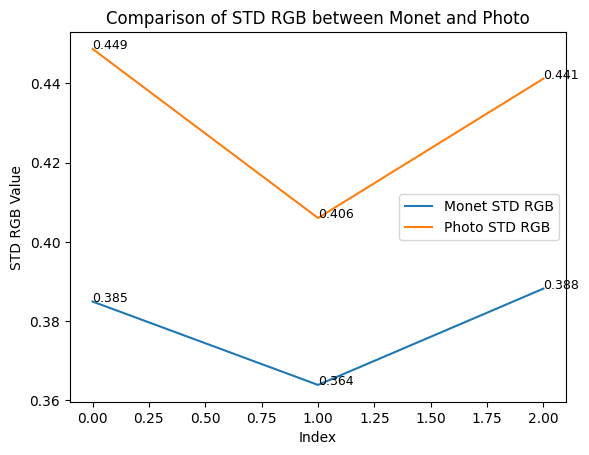

In [ ]:
def plot_std (ds, label, fig_size=(20, 15)):
    std = []

    for image in ds:
        std.append(tf.math.reduce_std(image, axis=[0,1]).numpy())

    std = np.mean(std, axis=0)

    plt.plot(std, label = label)


    for i, value in enumerate(std):
        plt.text(i, value, f'{value:.3f}', fontsize=9, ha='left')

    plt.title('Comparison of STD RGB between Monet and Photo')
    plt.xlabel('Index')
    plt.ylabel('STD RGB Value')
    plt.legend()

plot_std(monet_ds, 'Monet STD RGB')
plot_std(photo_ds, 'Photo STD RGB')


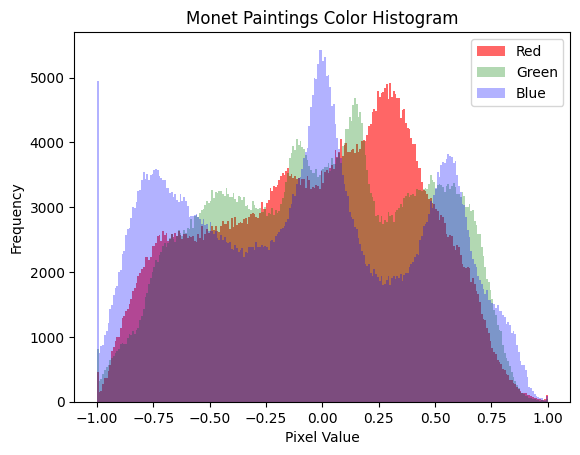

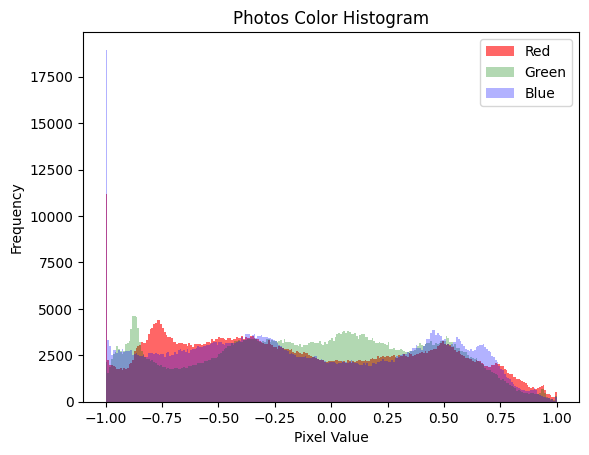

In [ ]:
def plot_color_analyst(ds, title):
    reds, greens, blues = [], [], []
    for image in ds.take(10):
        reds.extend(image.numpy()[:, :, 0].flatten())
        greens.extend(image.numpy()[:, :, 1].flatten())
        blues.extend(image.numpy()[:, :, 2].flatten())


    plt.hist(reds, bins=256, color='red', alpha=0.6, label='Red')
    plt.hist(greens, bins=256, color='green',alpha=0.3, label='Green')
    plt.hist(blues, bins=256, color='blue', alpha=0.3, label='Blue')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

plot_color_analyst(monet_ds, 'Monet Paintings Color Histogram')
plot_color_analyst(photo_ds, 'Photos Color Histogram')

# Build Models

GAN: GAN model is great for generating new images based on training data. It has one generator and one discriminator.

CycleGAN: CycleGAN model is great for transferring images to different styles or domains. It usually has two generators and two discriminators.

### Because our project focuses on transferring photos to Monet style, I believe CycleGAN is a better choice for this project.

The models I will be experimenting with are:

Model 1. CycleGAN with residual blocks
  It uses residual blocks to capture the high level details of Monet's style. Such as  overall scene and style.

Model 2. CycleGAN U-Net
  U-Net uses skip connections to capture the lower level details of Monet's style. Such as color, textures.



#### Model 1: CycleGAN with Residual Blocks



In [ ]:
kernel_initializer = tf.random_normal_initializer(0., 0.02)

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Encoder - reduce the resolution to capture the underlying pattern
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=kernel_initializer, use_bias=False)(inputs)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.ReLU()(x)

    # Residual blocks - capture the high level details from the encoder
    for _ in range(6):
        res = layers.Conv2D(256, 3, padding='same', kernel_initializer=kernel_initializer, use_bias=False)(x)
        res = layers.GroupNormalization(groups=-1)(res)
        res = layers.ReLU()(res)

        res = layers.Conv2D(256, 3, padding='same', kernel_initializer=kernel_initializer, use_bias=False)(res)
        res = layers.GroupNormalization(groups=-1)(res)
        res = layers.ReLU()(res)

        res = layers.Conv2D(256, 3, padding='same', kernel_initializer=kernel_initializer, use_bias=False)(res)
        res = layers.GroupNormalization(groups=-1)(res)

        x = layers.Add()([x, res])


    # Decorder - resconstruct the resolution of the image
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.ReLU()(x)

    output = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                    kernel_initializer=kernel_initializer, activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=output)



monet_generator = Generator()


In [ ]:
def Discriminator():
    inputs = layers.Input(shape=[256, 256, 3])

    x = inputs

    # Encoder - reduce the resolution for feature extraction
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)

    # Making decision
    output = layers.Conv2D(1, 4, strides=1, padding='same',
                         kernel_initializer=kernel_initializer)(x)

    return tf.keras.Model(inputs=inputs, outputs=output)


monet_discriminator = Discriminator()


In [ ]:
# Generator loss and discriminator loss to help train the model

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss(tf.ones_like(real), real)
    generated_loss = loss(tf.zeros_like(generated), generated)
    disc_loss = real_loss + generated_loss
    return disc_loss * 0.5


def identity_loss(real_image, copy_image, lambda_identity=5):
    loss = tf.reduce_mean(tf.abs(real_image - copy_image))
    return lambda_identity * loss

def generator_loss(generated, real_image, copy_image, lambda_identity=5):

    adv_loss = loss(tf.ones_like(generated), generated)
    id_loss = identity_loss(real_image, copy_image, lambda_identity = 5)
    gen_loss = adv_loss + id_loss

    return gen_loss



#### CycleGAN usually have two generators and two discriminators. Such as Photo - Monet and Monet - photo. Because our project focuses on transferring photos to Monet style. I have simplified the train_step and loss functions to focus only on Photo - Monet transfer.

In [ ]:
# Function to updating generator and discriminator

@tf.function
def train_step(real_photo, real_monet):
    real_photo = tf.expand_dims(real_photo, axis=0)
    real_monet = tf.expand_dims(real_monet, axis=0)

    with tf.GradientTape(persistent=True) as tape:
        # transfer photo to Monet's style
        fake_monet = monet_generator(real_photo, training=True)

        # copy the real monet using monet_generator
        copy_monet = monet_generator(real_monet, training=True)

        # discriminate the real and fake Monet
        disc_real = monet_discriminator(real_monet, training=True)
        disc_fake = monet_discriminator(fake_monet, training=True)

        # calculate the losses
        gen_loss = generator_loss(disc_fake, real_monet, copy_monet)

        disc_loss = discriminator_loss(disc_real, disc_fake)

    # calculate the gradients and apply it
    gen_gradients = tape.gradient(gen_loss, monet_generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients, monet_generator.trainable_variables))

    disc_gradients = tape.gradient(disc_loss, monet_discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_gradients, monet_discriminator.trainable_variables))


    return gen_loss

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
# Training the model

gen_loss_res = []

def train(photo_ds, monet_ds, epochs):
    for epoch in range(epochs):

        for real_photo, real_monet in tf.data.Dataset.zip((photo_ds, monet_ds)):
            gen_loss = train_step(real_photo, real_monet)

        gen_loss_res.append(gen_loss)
        print(f'Epoch {epoch + 1}, generator loss : {gen_loss:.2f}')


train(photo_ds, monet_ds, 10)

Epoch 1, generator loss : 1.78
Epoch 2, generator loss : 1.66
Epoch 3, generator loss : 1.76
Epoch 4, generator loss : 1.51
Epoch 5, generator loss : 1.79
Epoch 6, generator loss : 1.74
Epoch 7, generator loss : 1.90
Epoch 8, generator loss : 1.86
Epoch 9, generator loss : 1.39
Epoch 10, generator loss : 1.47


#### Model 1 Residual Block Result - Transferred Image Visualization

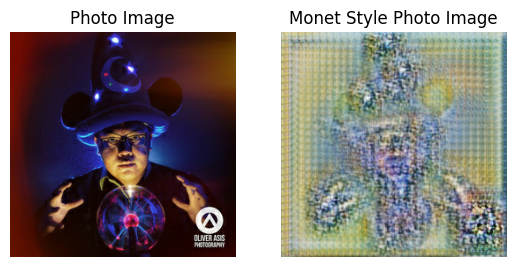

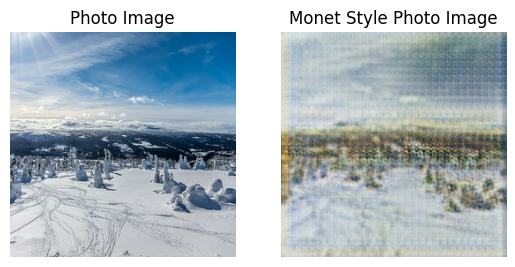

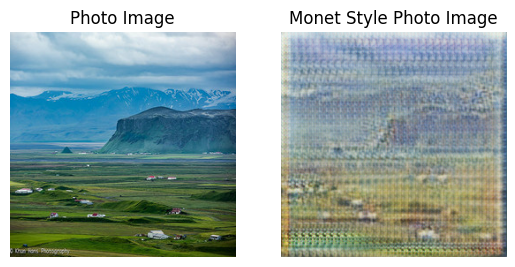

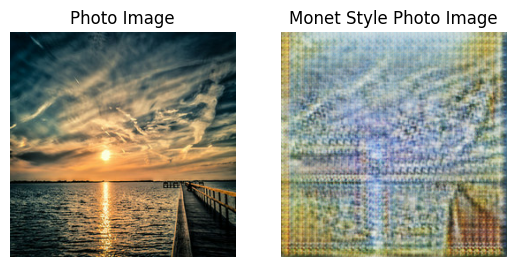

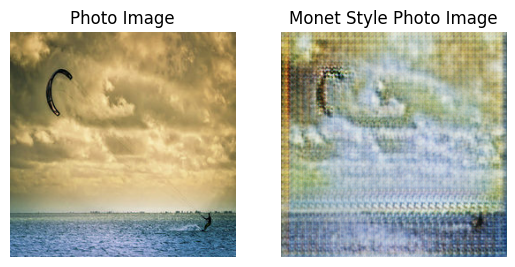

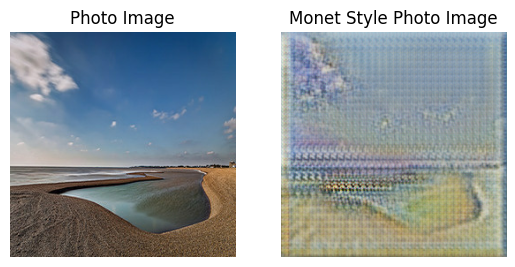

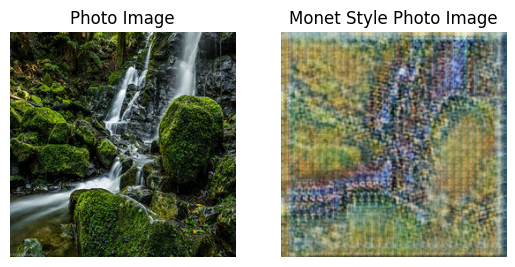

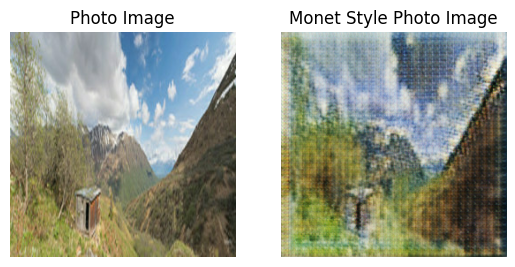

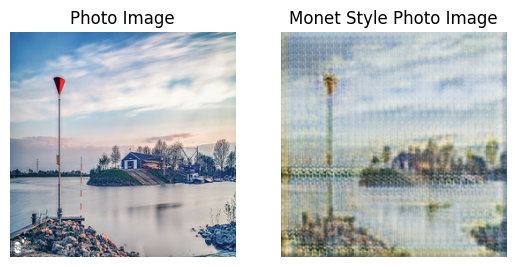

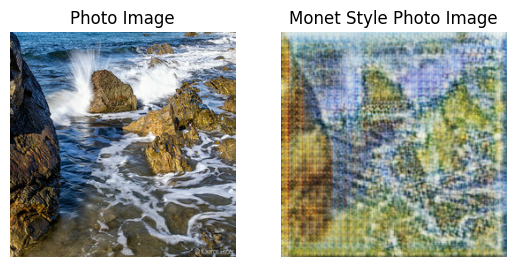

In [ ]:
# Visualization of transferred Image

for photo in photo_ds.take(10):

  photo = tf.expand_dims(photo, axis=0)
  monet_photo = monet_generator(photo, training = True)[0]

  for i,image in enumerate([photo[0], monet_photo]):

    plt.subplot(1, 2, i+1)
    plt.title(['Photo Image', 'Monet Style Photo Image'][i])
    image = (image * 0.5) + 0.5
    plt.imshow(image.numpy())
    plt.axis('off')
  plt.show()

## Model 2 （Different Models Comparison /Hyperparameter） - U-Net style


In [ ]:
kernel_initializer=tf.random_normal_initializer(0., 0.02)

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    x = inputs
    skips = []

    # Encoder - reduce the resolution to capture the underlying pattern
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    x = layers.Conv2D(512, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    x = layers.Conv2D(512, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    x = layers.Conv2D(512, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    x = layers.Conv2D(512, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)

    x = layers.Conv2D(512, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    skips.append(x)


    # skip connections - capture the lower level details from the encoder
    skips = reversed(skips[:-1])



    # Decorder - resconstruct the resolution of the image
    x = layers.Conv2DTranspose(512, 4, strides=2, padding='same',
                                     kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Concatenate()([x, next(skips)])

    x = layers.Conv2DTranspose(512, 4, strides=2, padding='same',
                                     kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Concatenate()([x, next(skips)])

    x = layers.Conv2DTranspose(512, 4, strides=2, padding='same',
                                     kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Concatenate()([x, next(skips)])

    x = layers.Conv2DTranspose(512, 4, strides=2, padding='same',
                                     kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Concatenate()([x, next(skips)])

    x = layers.Conv2DTranspose(256, 4, strides=2, padding='same',
                                     kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Concatenate()([x, next(skips)])

    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same',
                                     kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Concatenate()([x, next(skips)])

    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same',
                                     kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Concatenate()([x, next(skips)])


    output = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=kernel_initializer,
                                  activation='tanh')(x)

    return keras.Model(inputs=inputs, outputs=output)


monet_generator = Generator()


In [ ]:

def Discriminator():
    inputs = layers.Input(shape=[256, 256, 3])
    x = inputs


    # Encoder - reduce the resolution for feature extraction
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=kernel_initializer, use_bias=False)(x)
    x = layers.GroupNormalization(groups=-1)(x)
    x = layers.LeakyReLU()(x)

    # Making decision
    output = layers.Conv2D(1, 4, strides=1, padding='same',
                         kernel_initializer=kernel_initializer)(x)

    return tf.keras.Model(inputs=inputs, outputs=output)

monet_discriminator = Discriminator()


In [ ]:
# Generator loss and discriminator loss to help train the model

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss(tf.ones_like(real), real)
    generated_loss = loss(tf.zeros_like(generated), generated)
    disc_loss = real_loss + generated_loss
    return disc_loss * 0.5


def identity_loss(real_image, copy_image, lambda_identity=5):
    loss = tf.reduce_mean(tf.abs(real_image - copy_image))
    return lambda_identity * loss

def generator_loss(generated, real_image, copy_image, lambda_identity=5):

    adv_loss = loss(tf.ones_like(generated), generated)
    id_loss = identity_loss(real_image, copy_image, lambda_identity = 5)
    gen_loss = adv_loss + id_loss

    return gen_loss


#### CycleGAN usually have two generators and two discriminators. Such as Photo - Monet and Monet - photo. Because our project focuses on transferring photos to Monet style. I have simplified the train_step and loss functions to focus only on Photo - Monet transfer.

In [ ]:
# Function to updating generator and discriminator

@tf.function
def train_step(real_photo, real_monet):
    real_photo = tf.expand_dims(real_photo, axis=0)
    real_monet = tf.expand_dims(real_monet, axis=0)

    with tf.GradientTape(persistent=True) as tape:
        # transfer photo to Monet's style
        fake_monet = monet_generator(real_photo, training=True)

        # copy the real monet using monet_generator
        copy_monet = monet_generator(real_monet, training=True)

        # discriminate the real and fake Monet
        disc_real = monet_discriminator(real_monet, training=True)
        disc_fake = monet_discriminator(fake_monet, training=True)

        # calculate the losses
        gen_loss = generator_loss(disc_fake, real_monet, copy_monet)

        disc_loss = discriminator_loss(disc_real, disc_fake)

    # calculate the gradients and apply it
    gen_gradients = tape.gradient(gen_loss, monet_generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients, monet_generator.trainable_variables))

    disc_gradients = tape.gradient(disc_loss, monet_discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_gradients, monet_discriminator.trainable_variables))


    return gen_loss

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
# Training the model

gen_loss_unet = []

def train(photo_ds, monet_ds, epochs):
    for epoch in range(epochs):

        for real_photo, real_monet in tf.data.Dataset.zip((photo_ds, monet_ds)):
            gen_loss1 = train_step(real_photo, real_monet)

        gen_loss_unet.append(gen_loss1)
        print(f'Epoch {epoch + 1}, generator loss : {gen_loss1:.2f}')

train(photo_ds, monet_ds, 10)


Epoch 1, generator loss : 1.52
Epoch 2, generator loss : 1.96
Epoch 3, generator loss : 1.74
Epoch 4, generator loss : 1.59
Epoch 5, generator loss : 1.69
Epoch 6, generator loss : 1.43
Epoch 7, generator loss : 1.30
Epoch 8, generator loss : 1.29
Epoch 9, generator loss : 0.88
Epoch 10, generator loss : 0.95


#### Model 2 U-Net Result - Transferred Image Visualization

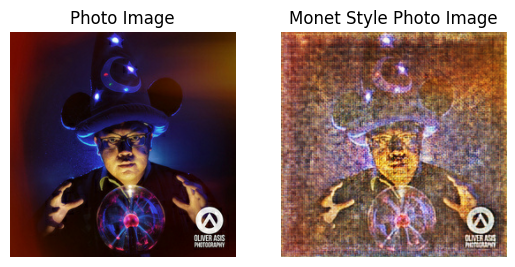

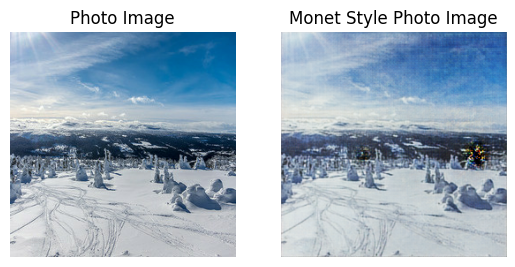

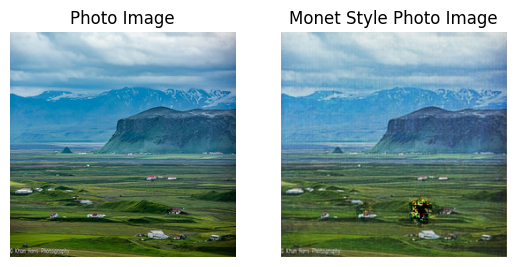

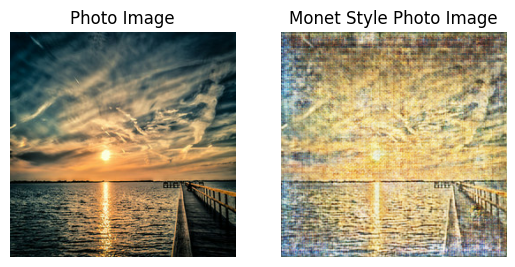

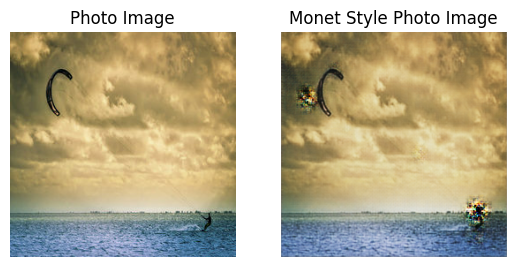

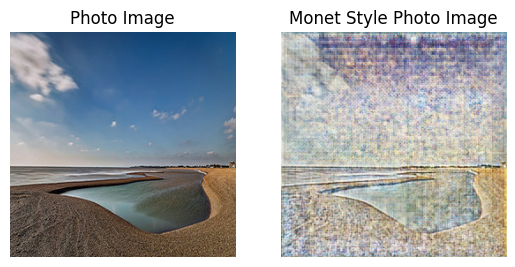

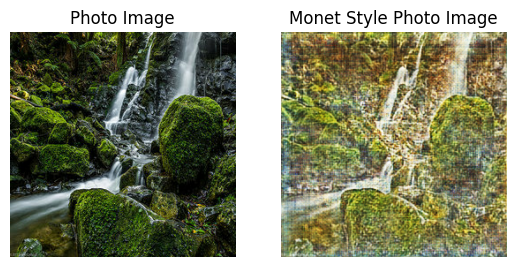

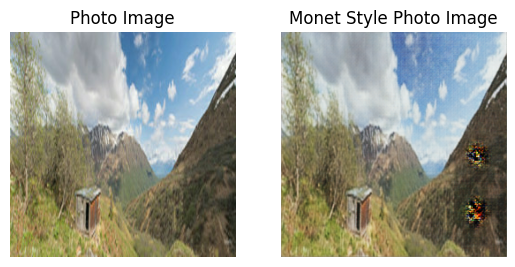

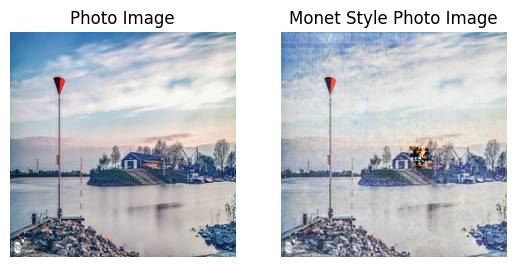

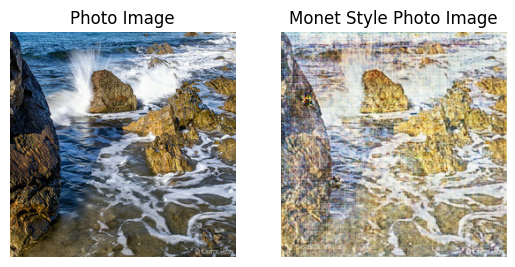

In [ ]:
# Visualization of transferred Image
for photo in photo_ds.take(10):

  photo = tf.expand_dims(photo, axis=0)
  monet_photo = monet_generator(photo, training = True)[0]

  for i,image in enumerate([photo[0], monet_photo]):

    plt.subplot(1, 2, i+1)
    plt.title(['Photo Image', 'Monet Style Photo Image'][i])
    image = (image * 0.5) + 0.5
    plt.imshow(image.numpy())
    plt.axis('off')
  plt.show()

### Summary Generator Loss Comparison Plot

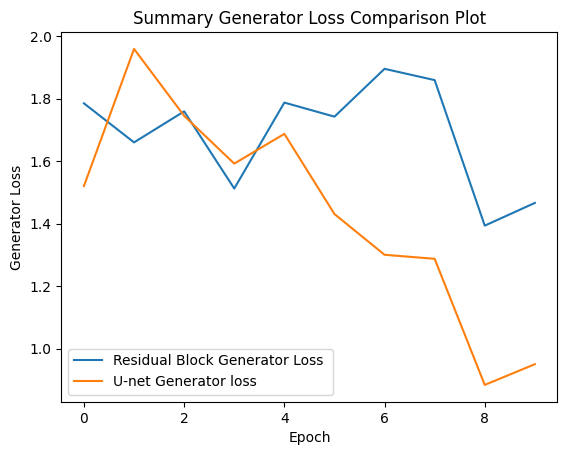

In [ ]:
plt.plot(gen_loss_res)
plt.plot(gen_loss_unet)
plt.title('Summary Generator Loss Comparison Plot')
plt.ylabel('Generator Loss')
plt.xlabel('Epoch')
plt.legend(['Residual Block Generator Loss ', 'U-net Generator loss'], loc='lower left')
plt.show()


# Hyperparameter tuning / Compare different model architectures

1. Normalizations:

  I experimented with three normalizations.  

  Batch Normalization is sensitive to small batches. Since we are transferring images one by one. The result shows the grey image.

  Group normalization groups image into small groups and it can capture more details than Instance Normalization. Group normalization shows the best result.


2. Model 1. CycleGAN with residual blocks.

  a. encoder to capture patterns

  b. residual blocks to capture the high level details of Monet's style

  c. decoder to generator photo

#### The result is not great. I can see Monet's style in the transferred photos, but the resolution of the transferred photos is low.

3. I experiment with CycleGAN U-net. Because the skip connections are focused on capturing the lower level of details.

  Model 2. CycleGAN U-Net

  a. encoder to capture patterns

  b. skip connections to capture the lower level details of Monet's style

  c. decoder to generator photo

#### The result is great. The resolution of the transferred photos is high with the Monet style.

# Result and Analysis:

From the summary generator loss comparison plot and model 1/model 2 Image Visualization after transfer, we can see, that CycleGAN with U-net style has the best performance.
It has a lower generator loss and its Monet-style photo's resolution is much higher.



In [ ]:
# Transfer all Photos to Monet's style for submissions

# os.makedirs('transfered_monet_images', exist_ok=True)

# def transfer_images(model, ds):

#   for i, photo in enumerate(ds):

#     image = model(tf.expand_dims(photo, axis=0), training=False)[0]

#     image = (image + 1.0) * 127.5

#     image = tf.cast(image, tf.uint8)

#     image_object = Image.fromarray(image.numpy())

#     img_object.save(os.path.join('transfered_monet_images', f"image_{i}.jpg"))



# transfer_images(monet_generator, photo_ds)



# Conclusion:

After an experiment with CycleGAN with U-net style. The performance of the model improved significantly. The generator loss is lower. The transferred photo shows the monet style with a high resolution.

# Learning and Takeaways:

1. Working with TFrecords files:

  I have learned how to load, store and preprocessing TFrecords files

2. Difference between GAN and CycleGAN.

  The GAN model is great for generating new images based on training data. It has one generator and one discriminator.

  The CycleGAN model is great for transferring images to different styles or domains. It usually has two generators and two discriminators.

3. Experimented with different architectures CycleGAN.

  CycleGAN residual blocks are focused on high level details.

  CycleGAN U-net is focused on lower-level details.

4. Experimented with different normalization Techniques.

  I have experimented with batch, instance and group normalization. Group normalization has the best result.

# Improvements:

Due to the limitation of the GPU, I can only run 10 epochs. If I have access to more GPU, I would be interested in running more epochs.
The overall Monet style in photos is not strong enough, such as landscape photos. I would like to experiment with a pre-trained model and CycleGAN together to improve the result.


# References:

1. Amyjang. (2020, August 29). Monet CycleGAN Tutorial. Kaggle. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial


2. Team, K. (n.d.). Keras documentation: CycleGAN. https://keras.io/examples/generative/cyclegan/

3. Eishkaran. (2023, June 13). CycleGan Implementation 🚀. Kaggle. https://www.kaggle.com/code/eishkaran/cyclegan-implementation#Building-GAN-Architecture

4. Dazhengzhu. (2024, September 16). Monet imagen. Kaggle. https://www.kaggle.com/code/dazhengzhu/monet-imagen#Submission

5. Chongzhenjie. (2023, May 6). Photo to Monet — CycleGAN⚡PyTorch Lightning. Kaggle. https://www.kaggle.com/code/chongzhenjie/photo-to-monet-cyclegan-pytorch-lightning
